## Notebook to calculate cellular growth rate and productivity using Hynes et al. 2023 method

In [216]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import datetime
import xarray as xr
from scipy import stats
from astral import Observer
from astral.sun import sunrise
from astral.sun import sunset

# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

In [217]:
#import zinser data over
# read in flow cytometry data
culture_data=pd.read_csv('simulation_data/zinser_figure2a.csv')
psd_data=pd.read_csv('simulation_data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('simulation_data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get abundance
pro_data['abundance']=ds.abundance.values
# get c-fixation and loss data
gt = xr.open_dataset('simulation_data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
# add net c-fiszation for all rows
pro_data['NPP'] = pro_data['GPP']-pro_data['carbonloss']


# create 10 day simulated data for Qc data
ten_days=generate_simulated(pro_data, 10)

# add a sub row for sunrise in day 1
new_row = pd.DataFrame({'hour':0, 'Qc_hour':np.nan, 'par':np.nan,
                        'abundance':np.nan, 'GPP':np.nan, 'carbonloss':np.nan,
                        'NPP':np.nan},
                                                            index =[0])

# add to top of df
ten_days=pd.concat([new_row, ten_days]).reset_index(drop = True)
# reset hours
ten_days.hour=np.arange(0,len(ten_days)*2,2)

# set each experiment day
ten_days['experiment_day']=ten_days['hour'] // 24

### get necessary data for annette's model

In [197]:
# in 10 days, first sunrise starts at idx 7 (hour 14 in experiment)
# next sunrise occurs 24 hours later (idx 19, hour 38)#
# "day" lengths are 16 hours (night are 8)
sunrise_hours=np.arange(7, len(ten_days), 12)
sunrise_abund=ten_days.loc[sunrise_hours, 'abundance']
day_len=16

## Calculate growth rate
Growth rate is calculate by fitting an exponential cellullar growth function to the Qc data. This is equivalent to calculating the linear relationship of growth to the log Qc at a given time for each day: 

$ln(Qc) = r \times t + ln(Qc_0)$

Then, slope (r) is tested to be significant or not via p-value (<=0.05). 
<br>
OHhh this is the daily averaged cellular growth rate (h-1)

In [173]:
# y = mx+b
# y-b=mx
## 1: subtract y intercept from original y
## 2: fit linear regression model to mx (on centered y)
## 3: add y intercept back to adjust values

-3.209012407231112 [0.0816897] 0.9120935456642124


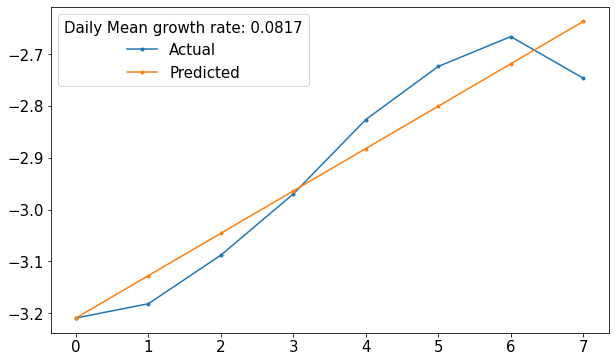

In [215]:
from sklearn.linear_model import LinearRegression
# get data to fit
day1_test = ten_days.loc[(ten_days['experiment_day']==1) &(ten_days['par']>0)]
X = np.arange(0, len(day1_test)).reshape(-1, 1)
y = np.log(day1_test['Qc_hour'].values)

# add y intercent, log Qc at sunrise
y_int=np.log(day1_test.loc[day1_test.hour%24==0, 'Qc_hour']).values[0]

# Step 1: Subtract the known y-intercept from all y values
y_centered = y - y_int

# Step 2: Fit the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(X, y_centered)

# Step 3: Add the known y-intercept back to the model's intercept
model.intercept_ += y_int

# step 4: get new y values
pred=model.predict(X)
slope=model.coef_

print(model.intercept_, model.coef_, model.score(X, y))
# plot
fig,axs=plt.subplots(figsize=(10,6))
# plot original values
axs.plot(X.flatten(),y.flatten(), marker='.', label='Actual')
# plot new predicted valyes
axs.plot(X.flatten(), pred.flatten(), marker='.', label='Predicted')
axs.legend(title=f'Daily Mean growth rate: {np.round(slope[0],4)}')

In [100]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

day1_test = ten_days.loc[ten_days['experiment_day']==1]
X = day1_test['hour']
Y = np.log(day1_test['Qc_hour'])
# add y intercent, log Qc at sunrise
y_int=np.log(day1_test.loc[day1_test.hour%24==0, 'Qc_hour']).values[0]
X = sm.add_constant(X)
X.const=y_int
# fit linear gression
model=sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qc_hour   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.4831
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.503
Time:                        13:32:05   Log-Likelihood:                 3.4278
No. Observations:                  12   AIC:                            -2.856
Df Residuals:                      10   BIC:                            -1.886
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8668      0.093      9.281      0.000       0.659       1.075
hour          -0.0058      0.008     -0.695      0.503      -0.024       0.013
==============================================================================
Omnibus:                        2.212   Durbin-Watson:                   0.290
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                0.932
Skew:                           0.109   Prob(JB):                        0.628
Kurtosis:                       1.653   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
import statsmodels.api as sm
def fit_regression(group):
    X = group['hour']
    y = group['Qc'].apply(lambda x: 0 if x == 0 else np.log(x))  # Avoid log of zero
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()  # Fit linear regression
    return model.summary2().tables[1]

In [57]:
# loop through each day
for day in pd.unique(ten_days['experiment_day']):
    # get subset and light values only 
    sub = ten_days.loc[(ten_days['experiment_day'] == day)&
                       (ten_days['par']>0)]
    # fit linear regression
    

,hour,Qc_hour,par,abundance,GPP,carbonloss,NPP,experiment_day
0,0,0.043129,148.279626,64246741,4.948369e-03,0.002057,0.002891,0
1,2,0.047061,199.521423,66670700,6.556686e-03,0.003401,0.003156,0
2,4,0.053032,226.445848,66973949,7.574984e-03,0.003777,0.003798,0
3,6,0.060581,226.069041,62140320,8.414698e-03,0.005229,0.003185,0
4,8,0.066867,224.277784,65727501,7.187658e-03,0.004913,0.002275,0
...,...,...,...,...,...,...,...,...
115,230,0.058370,0.000000,143526371,4.005195e-05,0.001653,-0.001613,9
116,232,0.050111,0.000000,157966322,-2.800356e-07,-0.001469,0.001468,9
117,234,0.044922,0.000000,186351250,7.095304e-07,-0.000064,0.000065,9
118,236,0.041898,0.000000,200282742,-1.809134e-08,-0.000978,0.000978,9


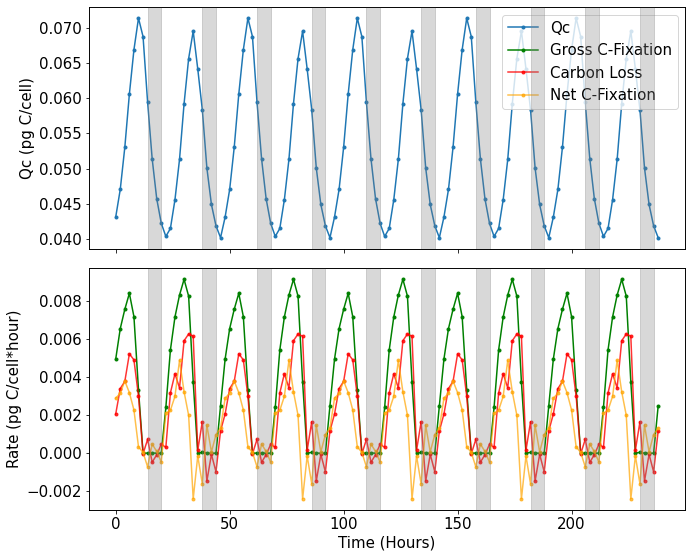

In [20]:
plot_simulated_rates(ten_days)

In [ ]:
## calculate carbon specific growth rate
# figure out when "sunrise" and "sunset is


## Let's look at noise while my other models are running
Vary noise using Signal to Noise Ratio

In [220]:
# calculates the signal to noise ratio
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

signaltonoise(ten_days.Qc_hour[1:])

array(5.22876578)

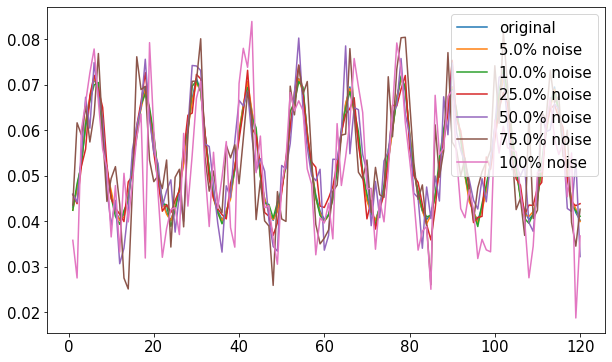

In [285]:
# add gaussian noise by varying std
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 

# data
x=ten_days.Qc_hour
# mean of noise = 0
mu=0.0

# make plot
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(x, label='original')

# vary the standard deviation by percentage
noise_percents=[0.05, 0.1, 0.25, 0.5, 0.75, 1]
for noise in noise_percents:
    # calculate std to sample from noise
    std = noise * np.std(x) 
    # add noise to data
    x_noisy=gaussian_noise(x,mu,std)
    axs.plot(x_noisy, label=f'{noise*100}% noise')
axs.legend(loc='upper right')

In [251]:
# number of trials to run
n_trials = 10
# data
x=ten_days.Qc_hour
samples=np.tile(x,(4,1))

fig_snr = []

# loop through trials and add noise
for idx, noise in enumerate([0.01, .10, .50, 1]):
    samples[idx] += np.random.randn(samples[idx].shape[0]) * noise

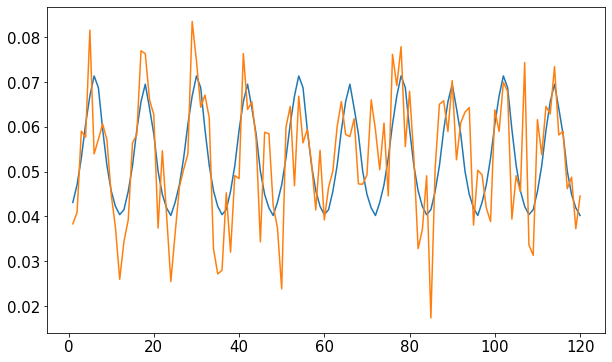

In [255]:
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(x, label='original')
axs.plot(samples[0])

In [218]:


sp = np.mean( x**2 ) # Signal Power

for snr in array_of_snr_values: 
    std_n = ( sp / snr )**0.5 # Noise std. deviation
        test_perdictive_model( std_n )

,hour,Qc_hour,par,abundance,GPP,carbonloss,NPP,experiment_day
0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,0.043129,148.279626,64246741.0,4.948369e-03,0.002057,0.002891,0
2,4,0.047061,199.521423,66670700.0,6.556686e-03,0.003401,0.003156,0
3,6,0.053032,226.445848,66973949.0,7.574984e-03,0.003777,0.003798,0
4,8,0.060581,226.069041,62140320.0,8.414698e-03,0.005229,0.003185,0
...,...,...,...,...,...,...,...,...
116,232,0.058370,0.000000,143526371.0,4.005195e-05,0.001653,-0.001613,9
117,234,0.050111,0.000000,157966322.0,-2.800356e-07,-0.001469,0.001468,9
118,236,0.044922,0.000000,186351250.0,7.095304e-07,-0.000064,0.000065,9
119,238,0.041898,0.000000,200282742.0,-1.809134e-08,-0.000978,0.000978,9


In [ ]:
import numpy as np
mean=0
std
gaussian_noise = np.random.normal(mean, std, shape)